In [33]:
import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
from scipy.interpolate import UnivariateSpline # curva sigmoide suavizada
import statsmodels.api as sm # estimação de modelos
import statsmodels.formula.api as smf # estimação do modelo logístico binário
from statstests.process import stepwise # procedimento Stepwise
from scipy import stats # estatística chi2
import plotly.graph_objects as go # gráficos 3D
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from statsmodels.discrete.discrete_model import MNLogit # estimação do modelo
                                                        #logístico multinomial
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, \
                            recall_score, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [34]:
def func_confusion_matrix(predicts, observed, cutoff):
    
    values = predicts.values
    
    binary_prediction = []
        
    for item in values:
        if item < cutoff:
            binary_prediction.append(0)
        else:
            binary_prediction.append(1)
           
    cm = confusion_matrix(binary_prediction, observed)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.xlabel('True')
    plt.ylabel('Classified')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()
        
    sensitivity  = recall_score(observed, binary_prediction, pos_label=1)
    specificity  = recall_score(observed, binary_prediction, pos_label=0)
    accuracy = accuracy_score(observed, binary_prediction)

    # main indicators of confusion matrix
    indicadores = pd.DataFrame({'sensitivity ':[sensitivity],
                                'specificity ':[specificity],
                                'accuracy':[accuracy]})
    return indicadores

def espec_sens(observed ,predicts):
    # add object with predicted values
    values = predicts.values
    
    # cutoff ranges that'll be analysed in steps of 0.01
    cutoffs = np.arange(0,1.01,0.01)
    
    # lists that will save specificity and sensitivity results
    list_sensitivity = []
    list_specificity = []
    
    for cutoff in cutoffs:
        binary_prediction = []
        
        # Definindo resultado binário de acordo com o predict
        for item in values:
            if item >= cutoff:
                binary_prediction.append(1)
            else:
                binary_prediction.append(0)
                
        # Cálculo da sensitividade e especificidade no cutoff
        sensitivity = recall_score(observed, binary_prediction, pos_label=1)
        specificity = recall_score(observed, binary_prediction, pos_label=0)
        
        # Adicionar valores nas listas
        list_sensitivity.append(sensitivity)
        list_specificity.append(specificity)
        
    # Criar dataframe com os resultados nos seus respectivos cutoffs
    resultado = pd.DataFrame({'cutoffs':cutoffs,'sensitivity':list_sensitivity,'specificity':list_specificity})
    return resultado

In [35]:
df_base_vars = pd.read_excel('E Commerce Dataset.xlsx')
df_base_vars.columns =  df_base_vars.iloc[0]
df_base_vars = df_base_vars.iloc[1:, 1:]
print(df_base_vars.to_string())

0     Data                     Variable                                                    Discerption
1   E Comm                   CustomerID                                             Unique customer ID
2   E Comm                        Churn                                                     Churn Flag
3   E Comm                       Tenure                             Tenure of customer in organization
4   E Comm         PreferredLoginDevice                             Preferred login device of customer
5   E Comm                     CityTier                                                      City tier
6   E Comm              WarehouseToHome              Distance in between warehouse to home of customer
7   E Comm         PreferredPaymentMode                           Preferred payment method of customer
8   E Comm                       Gender                                             Gender of customer
9   E Comm               HourSpendOnApp         Number of hours spend on 

In [36]:
# source: https://www.kaggle.com/datasets/ankitverma2010/ecommerce-customer-churn-analysis-and-prediction
df_base = pd.read_excel('E Commerce Dataset.xlsx', sheet_name='E Comm')
df_base

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,55626,0,10.0,Computer,1,30.0,Credit Card,Male,3.0,2,Laptop & Accessory,1,Married,6,0,18.0,1.0,2.0,4.0,150.71
5626,55627,0,13.0,Mobile Phone,1,13.0,Credit Card,Male,3.0,5,Fashion,5,Married,6,0,16.0,1.0,2.0,NaN,224.91
5627,55628,0,1.0,Mobile Phone,1,11.0,Debit Card,Male,3.0,2,Laptop & Accessory,4,Married,3,1,21.0,1.0,2.0,4.0,186.42
5628,55629,0,23.0,Computer,3,9.0,Credit Card,Male,4.0,5,Laptop & Accessory,4,Married,4,0,15.0,2.0,2.0,9.0,178.90


In [37]:
# replacing values that are white space or empty with NaN
df_base.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [38]:
df_base.isna().sum()

CustomerID                       0
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64

In [39]:
df_base.dropna(inplace=True)

In [40]:
df_base.duplicated().sum()

0

In [41]:
df_base['CustomerID'].duplicated().sum()

0

In [42]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3774 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   3774 non-null   int64  
 1   Churn                        3774 non-null   int64  
 2   Tenure                       3774 non-null   float64
 3   PreferredLoginDevice         3774 non-null   object 
 4   CityTier                     3774 non-null   int64  
 5   WarehouseToHome              3774 non-null   float64
 6   PreferredPaymentMode         3774 non-null   object 
 7   Gender                       3774 non-null   object 
 8   HourSpendOnApp               3774 non-null   float64
 9   NumberOfDeviceRegistered     3774 non-null   int64  
 10  PreferedOrderCat             3774 non-null   object 
 11  SatisfactionScore            3774 non-null   int64  
 12  MaritalStatus                3774 non-null   object 
 13  NumberOfAddress        

In [43]:
df_base[['Churn', 'Tenure', 'CityTier', 'WarehouseToHome', 
         'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore', 
         'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear',
         'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']].describe()

,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,3774.000000,3774.000000,3774.000000,3774.000000,3774.000000,3774.000000,3774.000000,3774.000000,3774.000000,3774.00000,3774.000000,3774.000000,3774.000000,3774.000000
mean,0.167197,8.776895,1.707737,15.743773,2.981187,3.754107,3.056439,4.216481,0.282194,15.72761,1.719661,2.825384,4.526232,164.213590
std,0.373201,7.678508,0.936725,8.594330,0.722158,1.025233,1.389730,2.562142,0.450127,3.62991,1.674508,2.467597,3.371310,24.093966
min,0.000000,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,1.000000,0.000000,11.00000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,9.000000,2.000000,3.000000,2.000000,2.000000,0.000000,13.00000,1.000000,1.000000,2.000000,148.485000
50%,0.000000,8.000000,1.000000,14.000000,3.000000,4.000000,3.000000,3.000000,0.000000,15.00000,1.000000,2.000000,3.000000,160.050000
75%,0.000000,13.000000,3.000000,21.000000,3.000000,4.000000,4.000000,6.000000,1.000000,18.00000,2.000000,3.000000,7.000000,178.010000
max,1.000000,51.000000,3.000000,127.000000,5.000000,6.000000,5.000000,22.000000,1.000000,26.00000,16.000000,16.000000,46.000000,324.990000


In [44]:
list_categoric_vars = df_base.drop(['CustomerID', 'Churn', 'Tenure', 'CityTier', 'WarehouseToHome', 
                                    'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore', 
                                    'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear',
                                    'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount'], axis=1).columns
for column in list_categoric_vars:
    print(df_base[column].value_counts().sort_index())
    print('-='*20)

PreferredLoginDevice
Computer        1111
Mobile Phone    1936
Phone            727
Name: count, dtype: int64
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
PreferredPaymentMode
CC                    35
COD                  301
Cash on Delivery      48
Credit Card         1124
Debit Card          1538
E wallet             443
UPI                  285
Name: count, dtype: int64
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Gender
Female    1503
Male      2271
Name: count, dtype: int64
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
PreferedOrderCat
Fashion                443
Grocery                  6
Laptop & Accessory    1961
Mobile                 119
Mobile Phone          1227
Others                  18
Name: count, dtype: int64
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
MaritalStatus
Divorced     547
Married     1982
Single      1245
Name: count, dtype: int64
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


In [45]:
# dummies for categoric variables
df_base_dummies = pd.get_dummies(df_base,
                                 columns=list_categoric_vars,
                                 dtype=int,
                                 drop_first=True)

In [65]:
df_base_dummies

,CustomerID,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,...,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_LaptopAndAccessory,PreferedOrderCat_Mobile,PreferedOrderCat_MobilePhone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single,phat
0,50001,1,4.0,3,6.0,3.0,3,2,9,1,...,0,0,0,1,0,0,0,0,1,0.326829
3,50004,1,0.0,3,15.0,2.0,4,5,8,0,...,0,1,0,1,0,0,0,0,1,0.702633
5,50006,1,0.0,1,22.0,3.0,5,5,2,1,...,0,0,0,0,0,1,0,0,1,0.890087
11,50012,1,11.0,1,6.0,3.0,4,3,10,1,...,0,1,0,0,0,0,0,0,1,0.618257
12,50013,1,0.0,1,11.0,2.0,3,3,2,1,...,0,1,0,0,1,0,0,0,1,0.713717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5624,55625,0,1.0,3,12.0,2.0,5,3,2,0,...,1,0,0,0,0,1,0,0,1,0.397326
5625,55626,0,10.0,1,30.0,3.0,2,1,6,0,...,0,1,0,1,0,0,0,1,0,0.007426
5627,55628,0,1.0,1,11.0,3.0,2,4,3,1,...,0,1,0,1,0,0,0,1,0,0.096874
5628,55629,0,23.0,3,9.0,4.0,5,4,4,0,...,0,1,0,1,0,0,0,1,0,0.000545


In [48]:
df_base_dummies.columns = df_base_dummies.columns.str.replace(' ', '').str.replace('&', 'And')

In [67]:
df_base_dummies.corr()

,CustomerID,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,...,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_LaptopAndAccessory,PreferedOrderCat_Mobile,PreferedOrderCat_MobilePhone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single,phat
CustomerID,1.000000,0.031617,-0.017339,-0.076098,0.043284,0.594250,0.387227,-0.028921,0.117903,-0.006115,...,0.022324,0.009760,0.015147,-0.125358,-0.171108,0.330379,0.027987,0.166812,0.003308,0.081240
Churn,0.031617,1.000000,-0.340013,0.073858,0.087318,0.060845,0.149041,0.095759,0.076336,0.238137,...,0.000938,0.033792,-0.017880,-0.184584,0.016675,0.181683,0.010208,-0.159808,0.179481,0.657285
Tenure,-0.017339,-0.340013,1.000000,-0.057414,-0.016353,-0.029818,-0.058752,-0.009972,0.196547,-0.035228,...,-0.043942,-0.052123,0.091251,0.104482,-0.033466,-0.211477,0.103702,0.085990,-0.103150,-0.543368
CityTier,-0.076098,0.073858,-0.057414,1.000000,0.004457,-0.070035,-0.008616,-0.019494,-0.046406,-0.006122,...,-0.036088,-0.018072,-0.001750,0.245824,-0.097493,-0.281079,-0.011248,-0.029876,0.017370,0.118031
WarehouseToHome,0.043284,0.087318,-0.016353,0.004457,1.000000,0.052731,0.024582,0.000434,0.003422,0.003829,...,-0.021470,0.035581,0.003512,0.043231,-0.015441,-0.028939,-0.035530,0.038336,-0.030496,0.139541
HourSpendOnApp,0.594250,0.060845,-0.029818,-0.070035,0.052731,1.000000,0.293021,0.039879,0.124962,0.020413,...,-0.030052,-0.009952,-0.017382,-0.130819,-0.112896,0.281309,0.023109,0.022257,-0.037134,0.098836
NumberOfDeviceRegistered,0.387227,0.149041,-0.058752,-0.008616,0.024582,0.293021,1.000000,-0.017788,0.066684,0.018881,...,0.010839,-0.026706,0.022548,-0.080608,-0.125343,0.188563,0.035364,-0.064517,0.069345,0.238180
SatisfactionScore,-0.028921,0.095759,-0.009972,-0.019494,0.000434,0.039879,-0.017788,1.000000,0.054627,-0.044533,...,0.009321,-0.032398,0.027097,-0.025448,-0.006238,0.011297,0.030401,-0.012167,-0.025659,0.153031
NumberOfAddress,0.117903,0.076336,0.196547,-0.046406,0.003422,0.124962,0.066684,0.054627,1.000000,-0.017363,...,0.007556,-0.030980,-0.005968,0.059515,-0.031229,-0.023102,-0.004349,-0.001463,0.020125,0.121992
Complain,-0.006115,0.238137,-0.035228,-0.006122,0.003829,0.020413,0.018881,-0.044533,-0.017363,1.000000,...,0.012421,-0.039522,0.004534,-0.018126,-0.005327,0.019793,0.007866,-0.000364,-0.009180,0.380563


In [50]:
# formula
columns_list = list(df_base_dummies.drop(columns=['CustomerID',
                                                  'Churn']).columns)
model_formula = ' + '.join(columns_list)
model_formula = 'Churn ~ ' + model_formula

# binary logistic regression
churn_model = sm.Logit.from_formula(model_formula, df_base_dummies).fit()
print(churn_model.summary())

         Current function value: 0.273087
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 3774
Model:                          Logit   Df Residuals:                     3744
Method:                           MLE   Df Model:                           29
Date:                Fri, 10 Jan 2025   Pseudo R-squ.:                  0.3950
Time:                        22:21:59   Log-Likelihood:                -1030.6
converged:                      False   LL-Null:                       -1703.6
Covariance Type:            nonrobust   LLR p-value:                3.491e-265
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -3.7385      1.054     -3.546      0.000      -5.805   

In [51]:
stepwise_model = stepwise(churn_model, pvalue_limit=0.05)
stepwise_model.summary()

Regression type: Logit 

Estimating model...: 
 Churn ~ Q('Tenure') + Q('CityTier') + Q('WarehouseToHome') + Q('HourSpendOnApp') + Q('NumberOfDeviceRegistered') + Q('SatisfactionScore') + Q('NumberOfAddress') + Q('Complain') + Q('OrderAmountHikeFromlastYear') + Q('CouponUsed') + Q('OrderCount') + Q('DaySinceLastOrder') + Q('CashbackAmount') + Q('PreferredLoginDevice_MobilePhone') + Q('PreferredLoginDevice_Phone') + Q('PreferredPaymentMode_COD') + Q('PreferredPaymentMode_CashonDelivery') + Q('PreferredPaymentMode_CreditCard') + Q('PreferredPaymentMode_DebitCard') + Q('PreferredPaymentMode_Ewallet') + Q('PreferredPaymentMode_UPI') + Q('Gender_Male') + Q('PreferedOrderCat_Grocery') + Q('PreferedOrderCat_LaptopAndAccessory') + Q('PreferedOrderCat_Mobile') + Q('PreferedOrderCat_MobilePhone') + Q('PreferedOrderCat_Others') + Q('MaritalStatus_Married') + Q('MaritalStatus_Single')
         Current function value: 0.273087
         Iterations: 35

 Discarding atribute "Q('PreferedOrderCat_Groce

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 3774
Model:                          Logit   Df Residuals:                     3754
Method:                           MLE   Df Model:                           19
Date:                Fri, 10 Jan 2025   Pseudo R-squ.:                  0.3931
Time:                        22:21:59   Log-Likelihood:                -1034.0
converged:                       True   LL-Null:                       -1703.6
Covariance Type:            nonrobust   LLR p-value:                1.369e-272
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -4.4494      0.448     -9.932      0.000      -5.327      -3.571
Q('Tenure')                                 -0.2454      0.014    -17.171      0.000      -0.273      -0.217
Q('CityTier')                                0.3243      0.072      4.481      0.000       0.182       0.466
Q('WarehouseToHome')                         0.0404      0.007      6.093      0.000       0.027       0.053
Q('NumberOfDeviceRegistered')                0.3857      0.061      6.275      0.000       0.265       0.506
Q('SatisfactionScore')                       0.2439      0.042      5.776      0.000       0.161       0.327
Q('NumberOfAddress')                         0.2369      0.022     10.725      0.000       0.194       0.280
Q('Complain')                                1.6530      0.119     13.857      0.000       1.419       1.887
Q('OrderCount')                              0.1719      0.029      5.887      0.000       0.115       0.229
Q('DaySinceLastOrder')                      -0.1288      0.024     -5.417      0.000      -0.175      -0.082
Q('PreferredLoginDevice_MobilePhone')       -0.4522      0.120     -3.765      0.000      -0.688      -0.217
Q('PreferredPaymentMode_COD')                0.4290      0.196      2.187      0.029       0.044       0.814
Q('PreferredPaymentMode_Ewallet')            0.4840      0.191      2.529      0.011       0.109       0.859
Q('Gender_Male')                             0.3004      0.117      2.562      0.010       0.071       0.530
Q('PreferedOrderCat_LaptopAndAccessory')    -1.7599      0.193     -9.134      0.000      -2.138      -1.382
Q('PreferedOrderCat_Mobile')                -0.9840      0.369     -2.667      0.008      -1.707      -0.261
Q('PreferedOrderCat_MobilePhone')           -0.8231      0.206     -3.988      0.000      -1.228      -0.419
Q('PreferedOrderCat_Others')                 2.5414      0.686      3.704      0.000       1.197       3.886
Q('MaritalStatus_Married')                  -0.3335      0.169     -1.970      0.049      -0.665      -0.002
Q('MaritalStatus_Single')                    0.7475      0.169      4.420      0.000       0.416       1.079
============================================================================================================
"""

In [52]:
df_base_dummies['phat'] = stepwise_model.predict() # adding predicted probability values to database

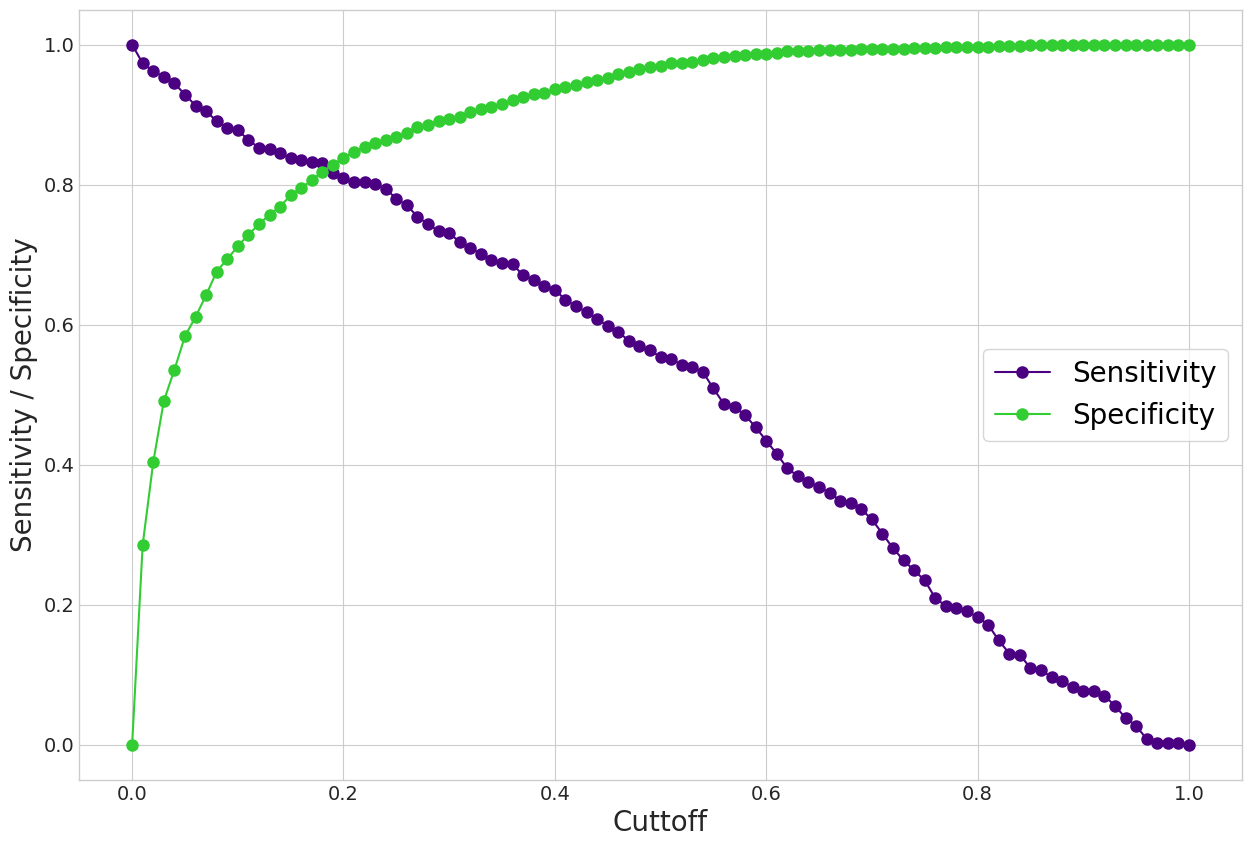

In [53]:
plot_data = espec_sens(observed = df_base_dummies['Churn'],
                            predicts = df_base_dummies['phat'])
plot_data

# showing variation of specificity and sensitivity in function of cutoff

plt.figure(figsize=(15,10))
with plt.style.context('seaborn-v0_8-whitegrid'):
    plt.plot(plot_data.cutoffs,plot_data.sensitivity, marker='o',
         color='indigo', markersize=8)
    plt.plot(plot_data.cutoffs,plot_data.specificity, marker='o',
         color='limegreen', markersize=8)
plt.xlabel('Cuttoff', fontsize=20)
plt.ylabel('Sensitivity / Specificity', fontsize=20)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.legend(['Sensitivity', 'Specificity'], fontsize=20)

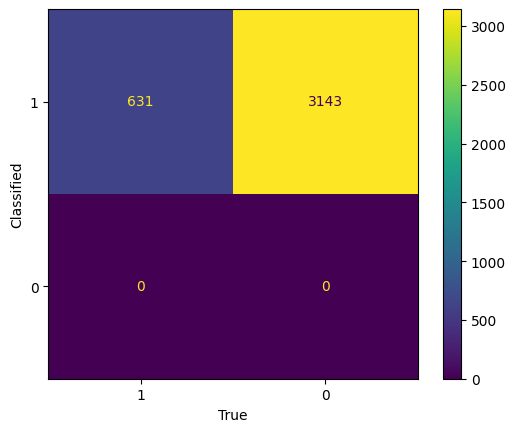

,sensitivity,specificity,accuracy
0,1.0,0.0,0.167197


In [54]:
func_confusion_matrix(observed=df_base_dummies['Churn'],
                    predicts=df_base_dummies['phat'],
                    cutoff=0)

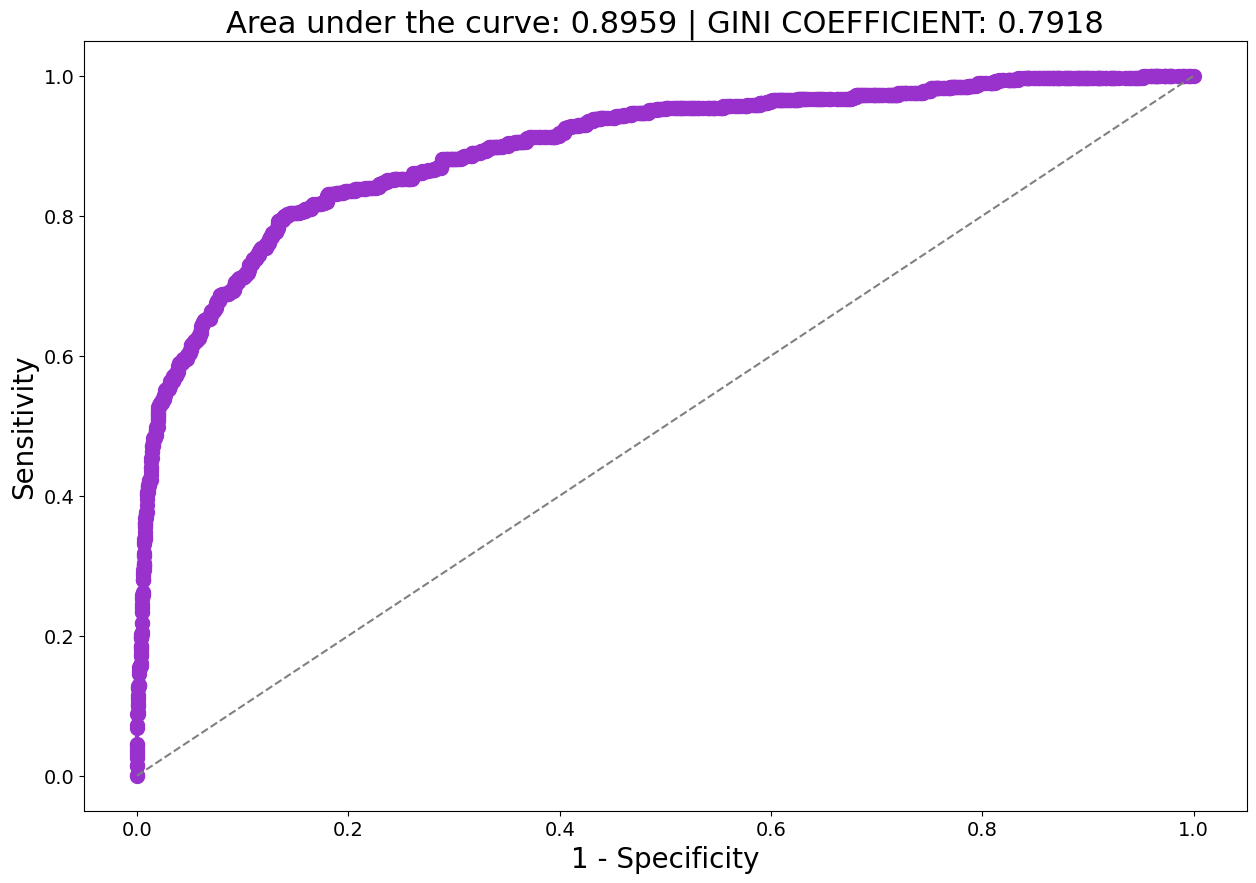

In [56]:
# roc_curve function from metrics package from sklearn
fpr, tpr, thresholds =roc_curve(df_base_dummies['Churn'], df_base_dummies['phat'])
roc_auc = auc(fpr, tpr)

# GINI coefficient calculation
gini = (roc_auc - 0.5)/(0.5)

# plotting ROC curve
plt.figure(figsize=(15,10))
plt.plot(fpr, tpr, marker='o', color='darkorchid', markersize=10, linewidth=3)
plt.plot(fpr, fpr, color='gray', linestyle='dashed')
plt.title('Area under the curve: %g' % round(roc_auc, 4) +
          ' | GINI COEFFICIENT: %g' % round(gini, 4), fontsize=22)
plt.xlabel('1 - Specificity', fontsize=20)
plt.ylabel('Sensitivity', fontsize=20)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.show()

In [63]:
# making a prediction
prob_pred = stepwise_model.predict(pd.DataFrame({'Tenure': [30],
                                                 'CityTier': [1],
                                                 'WarehouseToHome': [14],
                                                 'NumberOfDeviceRegistered': [3],
                                                 'SatisfactionScore': [3],
                                                 'NumberOfAddress': [4],
                                                 'Complain': [1],
                                                 'OrderCount': [2],
                                                 'DaySinceLastOrder': [4],
                                                 'PreferredLoginDevice_MobilePhone': [1],
                                                 'PreferredPaymentMode_COD': [0],
                                                 'PreferredPaymentMode_Ewallet': [1],
                                                 'Gender_Male': [0],
                                                 'PreferedOrderCat_LaptopAndAccessory': [0],
                                                 'PreferedOrderCat_Mobile': [0],
                                                 'PreferedOrderCat_MobilePhone': [1],
                                                 'PreferedOrderCat_Others': [0],
                                                 'MaritalStatus_Married': [0],
                                                 'MaritalStatus_Single': [1]}))

In [64]:
# the result shows the estimated mean probability of event occurence
print(f"Probability predicted: {round(prob_pred[0]*100, 2)}%")

Probability predicted: 0.13%
